In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)
from google.colab import output

In [3]:
from IPython.display import clear_output

In [6]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product
!pip install scikit-plot

In [7]:
from datetime import datetime
import time
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [8]:
train_set=torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()])
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [9]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [10]:
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [11]:
sample=next(iter(train_set))
print(len(sample))
print(type(sample))

2
<class 'tuple'>


In [12]:
image=sample[0]
label=sample[1]
print(image.shape)
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


label:  9


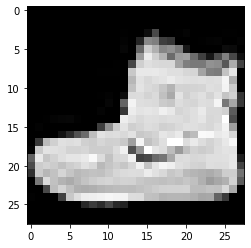

In [13]:
plt.imshow(image.squeeze(),cmap='gray')
print('label: ' ,label)

In [14]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=10)

In [15]:
train_loader

In [16]:
batch=next(iter(train_loader))
print(len(batch))
print(type(batch))


2
<class 'list'>


In [17]:
images,labels=batch

In [18]:
print(images.shape)
print(labels.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


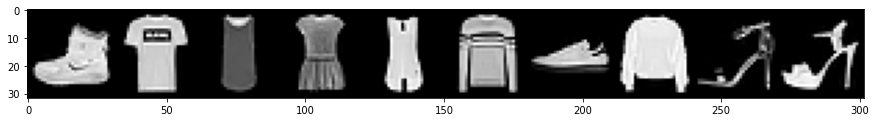

In [19]:
grid=torchvision.utils.make_grid(images,nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))

print("labels:", labels)

In [20]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1)
    self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.fc1=nn.Linear(in_features=192,out_features=120)
    self.fc2=nn.Linear(in_features=120,out_features=60)
    self.fc3=nn.Linear(in_features=60,out_features=10)

  def forward(self,t):
    #hidden conv layer 1
    t=self.conv1(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)
    #hidden conv layer 2
    t=self.conv2(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)
    #hidden linear layer
    t=t.reshape(-1,12*4*4)
    t=self.fc1(t)
    t=F.relu(t)
    #hidden linear layer
    t=self.fc2(t)
    t=F.relu(t)
     # output layer 
    t=self.fc3(t)
     #t=F.softmax(t,dim=1)
    return t


In [43]:
def get_num_correct(preds,labels):
  return preds.to('cuda').argmax(dim=1).eq(labels.to('cuda')).sum().item()

In [22]:
network1=Network()

In [23]:
print(network1)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


In [24]:
for name,weight in network1.named_parameters():
  print(name,weight.shape)

conv1.weight torch.Size([6, 1, 5, 5])
conv1.bias torch.Size([6])
conv2.weight torch.Size([12, 6, 5, 5])
conv2.bias torch.Size([12])
fc1.weight torch.Size([120, 192])
fc1.bias torch.Size([120])
fc2.weight torch.Size([60, 120])
fc2.bias torch.Size([60])
fc3.weight torch.Size([10, 60])
fc3.bias torch.Size([10])


In [25]:
print(network1.conv1.weight.shape)
print(network1.conv2.weight.shape)

torch.Size([6, 1, 5, 5])
torch.Size([12, 6, 5, 5])


# **Training in one block in a multiple epochs**

In [26]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple('Run',params.keys())
        runs=[]
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

In [27]:
class RunManager():
    def __init__(self):
        self.epoch_count=0
        self.epoch_loss=0
        self.epoch_num_correct=0
        self.epoch_start_time=None

        self.run_params=None
        self.run_count=0
        self.run_data=[]
        self.run_start_time=None

        self.network=None
        self.loader=None

    def begin_run(self,run,network,loader):
        self.run_start_time=time.time()

        self.run_params=run
        self.run_count+=1

        self.network=network
        self.loader=loader
        

    def end_run(self):
        self.epoch_count=0
    
    def begin_epoch(self):
        self.epoch_start_time=time.time()
        self.epoch_count+=1
        self.epoch_loss=0
        self.epoch_num_correct=0

    def end_epoch(self):
        epoch_duration=time.time()-self.epoch_start_time
        run_duration=time.time()-self.run_start_time

        loss=self.epoch_loss/len(self.loader.dataset)

        accuracy=self.epoch_num_correct/len(self.loader.dataset)

        results=OrderedDict()
        results["run"]=self.run_count
        results["epoch"]=self.epoch_count
        results["loss"]=loss
        results["accuracy"]=accuracy
        results["epoch_duration"]=epoch_duration
        results["run duration"] =run_duration
        for k,v in self.run_params._asdict().items():
            results[k]=v
            
        self.run_data.append(results)
        df=pd.DataFrame.from_dict(self.run_data,orient='columns')

        clear_output(wait=True)
        display(df)
        
    def track_loss(self,loss):
        self.epoch_loss+=loss.item()*self.loader.batch_size

    def track_num_correct(self,preds,labels):
        self.epoch_num_correct+=self.get_num_correct(preds,labels)

    def get_num_correct(self,preds,labels):
         return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self,filename):
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns'
        ).to_csv(f'{filename}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
             json.dump(self.run_data, f, ensure_ascii=False, indent=4)

    




In [29]:
params=OrderedDict(
    lr=[0.01],
    batch_size=[100],
    num_workers=[1],
    device=['cuda']

)
m=RunManager()
network=Network().to('cuda')
for run in RunBuilder.get_runs(params):
    device=torch.device(run.device)
    
    train_loader=torch.utils.data.DataLoader(train_set,batch_size=run.batch_size,num_workers=run.num_workers)
    optimizer=optim.Adam(network.parameters(),lr=run.lr)

    m.begin_run(run,network,train_loader)
    for epoch in range(10):
        m.begin_epoch()
        total_loss=0
        total_correct=0
        for batch in train_loader:

                   ##batch=next(iter(train_loader))
            images=batch[0].to(device)
            labels =batch[1].to(device)

            preds=network(images)#pass_batch
            loss=F.cross_entropy(preds,labels)#calculate loss
            optimizer.zero_grad()
            loss.backward() #call gradients
            optimizer.step() #update weight
            m.track_loss(loss)
            m.track_num_correct(preds,labels)
        
        m.end_epoch()
    m.end_run()

          
    

,run,epoch,loss,accuracy,epoch_duration,run duration,lr,batch_size,num_workers,device
0,1,1,0.615394,0.770933,6.316058,6.316065,0.01,100,1,cuda
1,1,2,0.399431,0.851850,6.285463,12.635356,0.01,100,1,cuda
2,1,3,0.364823,0.864933,6.338813,18.997523,0.01,100,1,cuda
3,1,4,0.346497,0.870583,6.150175,25.169455,0.01,100,1,cuda
4,1,5,0.337206,0.873917,6.154379,31.345993,0.01,100,1,cuda
5,1,6,0.333528,0.877100,6.151657,37.521179,0.01,100,1,cuda
6,1,7,0.322767,0.880150,6.515538,44.062014,0.01,100,1,cuda
7,1,8,0.323985,0.880550,6.344410,50.429266,0.01,100,1,cuda
8,1,9,0.321066,0.880883,6.216977,56.670047,0.01,100,1,cuda
9,1,10,0.317565,0.881917,6.689688,63.384490,0.01,100,1,cuda


# **Creating a confusion matrix**

**getting predictons on training set**

In [36]:
def get_all_preds(model,loader):
  all_preds=torch.tensor([]).to('cuda')
  for batch in loader:
    images1=batch[0].to('cuda')
    labels1=batch[1].to('cuda')
    preds=model(images1)
    all_preds=torch.cat((all_preds,preds),dim=0)
  return all_preds

In [37]:
prediction_loader=torch.utils.data.DataLoader(train_set,batch_size=1000)
train_preds=get_all_preds(network,prediction_loader)

In [38]:
train_preds.shape

torch.Size([60000, 10])

In [39]:
len(train_set.targets)

60000

In [44]:
preds_correct=get_num_correct(train_preds,train_set.targets)

In [45]:
print('total correct:',preds_correct)
print('accuracy:',preds_correct/len(train_set.targets))

total correct: 52659
accuracy: 0.87765


**CONFUSION MATRIX**

In [47]:
stacked=torch.stack((train_set.targets,train_preds.to('cpu').argmax(dim=1)),dim=1)

In [48]:
print(stacked.shape)
print(type(stacked))
print(stacked[0:10])

torch.Size([60000, 2])
<class 'torch.Tensor'>
tensor([[9, 9],
        [0, 0],
        [0, 0],
        [3, 3],
        [0, 0],
        [2, 2],
        [7, 7],
        [2, 4],
        [5, 5],
        [5, 5]], grad_fn=<SliceBackward>)


In [49]:
cmt=torch.zeros(10,10,dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [50]:
for p in stacked:
  true,predicted=p.tolist()
  cmt[true,predicted]=cmt[true,predicted]+1

In [51]:
cmt

tensor([[5526,   35,   46,  129,   16,    1,  212,    0,   35,    0],
        [   5, 5900,    0,   61,    6,    1,   11,    2,   12,    2],
        [ 112,   17, 4470,   89,  957,    1,  340,    1,   13,    0],
        [ 249,  138,    8, 5331,  175,    1,   83,    1,   11,    3],
        [  11,   19,  235,  220, 5066,    0,  424,    1,   24,    0],
        [   8,    0,    0,    0,    0, 5822,    0,   93,   41,   36],
        [1427,   42,  472,  152,  522,    0, 3325,    0,   60,    0],
        [   0,    0,    0,    0,    0,  124,    0, 5728,   61,   87],
        [  18,    8,   15,   13,   15,    5,   56,    7, 5862,    1],
        [   0,    0,    0,    0,    0,   48,    7,  310,    6, 5629]], dtype=torch.int32)

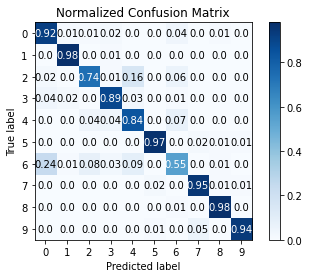

In [57]:
skplt.metrics.plot_confusion_matrix(train_set.targets,train_preds.to('cpu').detach().numpy().argmax(1), normalize=True)

In [ ]:
|